# Amazon Product Classification with CNN

In [1]:
import tensorflow as tf
 
# Display the version
print(tf.__version__)     
 
# other imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

2.8.3
Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Hyperparameters

In [2]:
batch_size = 32
epochs = 5
filter_size = 3
group_1_dim = 32
group_2_dim = 64
group_3_dim = 128
dense_dim = 1024

dropout_rate = 0.2

### Load the image data

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(r"C:\Users\kyley\Desktop\CS\C147\C147 Amazon Classification\img_uniform_split\train", 
                                                 labels='inferred', 
                                                 image_size=(64,64), 
                                                 batch_size=batch_size,
                                                 validation_split=0.2,
                                                 subset="training",
                                                 seed=123)

val_ds = tf.keras.utils.image_dataset_from_directory(r"C:\Users\kyley\Desktop\CS\C147\C147 Amazon Classification\img_uniform_split\train", 
                                                 labels='inferred', 
                                                 image_size=(64,64), 
                                                 batch_size=batch_size,
                                                 validation_split=0.2,
                                                 subset="validation",
                                                 seed=123)

test_ds = tf.keras.utils.image_dataset_from_directory(r"C:\Users\kyley\Desktop\CS\C147\C147 Amazon Classification\img_uniform_split\test", 
                                                 labels='inferred', 
                                                 image_size=(64,64), 
                                                 batch_size=batch_size)

class_names = train_ds.class_names

print(class_names)
print(train_ds.cardinality())
print(val_ds.cardinality())

Found 89663 files belonging to 10 classes.
Using 71731 files for training.
Found 89663 files belonging to 10 classes.
Using 17932 files for validation.
Found 9966 files belonging to 10 classes.
['arts, crafts & sewing', 'books', 'clothing, shoes & jewelry', 'electronics', 'grocery & gourmet food', 'health & personal care', 'musical instruments', 'patio, lawn & garden', 'sports & outdoors', 'toys & games']
tf.Tensor(2242, shape=(), dtype=int64)
tf.Tensor(561, shape=(), dtype=int64)


### Visualize images

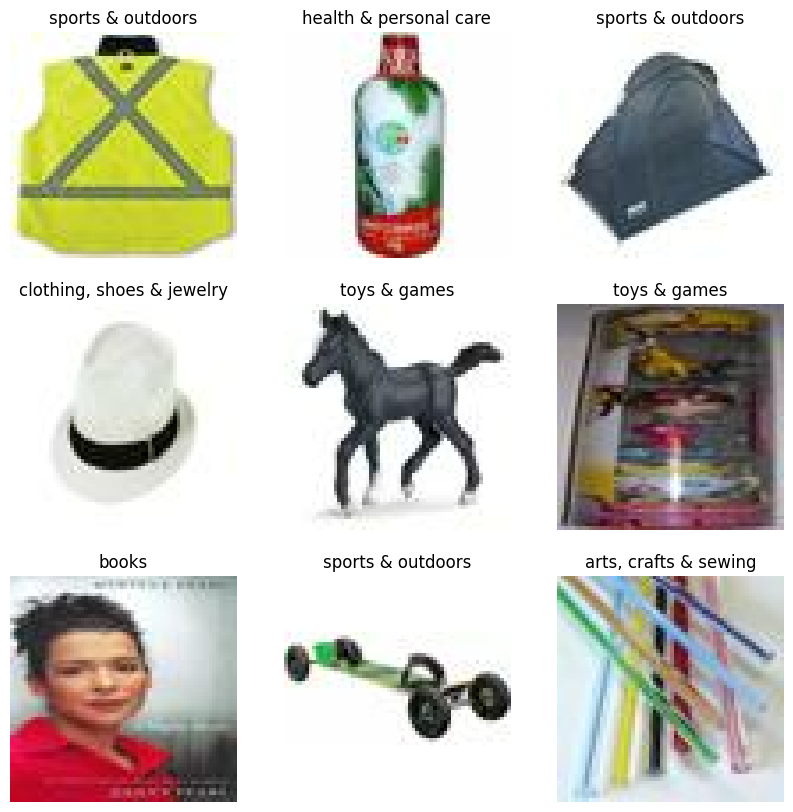

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Normalize Data

In [8]:
# # Reduce pixel values
# x_train, x_test = x_train / 255.0, x_test / 255.0
 
# # flatten the label values
# y_train, y_test = y_train.flatten(), y_test.flatten()

# Normalize pixel values
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


### Improve loading speed

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Data Augmentation

In [18]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
])

In [19]:
# Build the model using the functional API
# input layer
# i = Input(shape=x_train[0].shape)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
# x = BatchNormalization()(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D((2, 2))(x)
 
# x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D((2, 2))(x)
 
# x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D((2, 2))(x)

# x = Flatten()(x)
# x = Dropout(0.2)(x)
 
# # Hidden layer
# x = Dense(1024, activation='relu')(x)
# x = Dropout(0.2)(x)

# x = Dense(1024, activation='relu')(x)
# x = Dropout(0.2)(x)
 
# # last hidden layer i.e.. output layer
# x = Dense(K, activation='softmax')(x)
 
# model = Model(i, x)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  data_augmentation,
  
  # Group 1
  tf.keras.layers.Conv2D(group_1_dim, filter_size, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(group_1_dim, filter_size, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  
  # Group 2
  tf.keras.layers.Conv2D(group_2_dim, filter_size, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(group_2_dim, filter_size, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  
  # Group 3
  tf.keras.layers.Conv2D(group_3_dim, filter_size, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(group_3_dim, filter_size, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(dropout_rate),
  
  # Dense
  tf.keras.layers.Dense(dense_dim, activation='relu'),
  tf.keras.layers.Dropout(dropout_rate),
  
  tf.keras.layers.Dense(dense_dim, activation='relu'),
  tf.keras.layers.Dropout(dropout_rate),
  
  tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
])
 
# model.build()
# model.summary()

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
# Fit
with tf.device('/gpu:0'):
  r = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    # callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
  )

Epoch 1/100
2242/2242 [==============================] - 28s 12ms/step - loss: 2.0077 - accuracy: 0.2840 - val_loss: 2.2093 - val_accuracy: 0.2707
Epoch 2/100
2242/2242 [==============================] - 27s 12ms/step - loss: 1.8226 - accuracy: 0.3537 - val_loss: 1.7567 - val_accuracy: 0.3754
Epoch 3/100
2242/2242 [==============================] - 27s 12ms/step - loss: 1.7448 - accuracy: 0.3843 - val_loss: 1.9491 - val_accuracy: 0.3488
Epoch 4/100
2242/2242 [==============================] - 27s 12ms/step - loss: 1.6859 - accuracy: 0.4077 - val_loss: 1.7962 - val_accuracy: 0.3705
Epoch 5/100
2242/2242 [==============================] - 28s 12ms/step - loss: 1.6323 - accuracy: 0.4285 - val_loss: 1.7872 - val_accuracy: 0.3829
Epoch 6/100
2242/2242 [==============================] - 27s 12ms/step - loss: 1.5817 - accuracy: 0.4455 - val_loss: 1.8494 - val_accuracy: 0.3628
Epoch 7/100
2242/2242 [==============================] - 27s 12ms/step - loss: 1.5414 - accuracy: 0.4598 - val_loss: 1

KeyboardInterrupt: 

In [22]:
model.save(r'C:\Users\kyley\Desktop\CS\C147\amazon-product-classification\models\CNN_Image_Augmented_Real.keras')

### Evaluate Model

In [23]:
predictions = model.predict(test_ds)
prediction_df = pd.DataFrame(predictions, columns=class_names)
# print(prediction_df.head())

predicted_labels = np.argmax(predictions, axis=1)
# print(predicted_labels)

# Measure test accuracy
test_results = {}
test_results['model'] = model.evaluate(test_ds, verbose=0)

print(f" Accuracy: {test_results}")

 Accuracy: {'model': [2.095585823059082, 0.46889424324035645]}


<Axes: xlabel='Predicted Label', ylabel='True Label'>

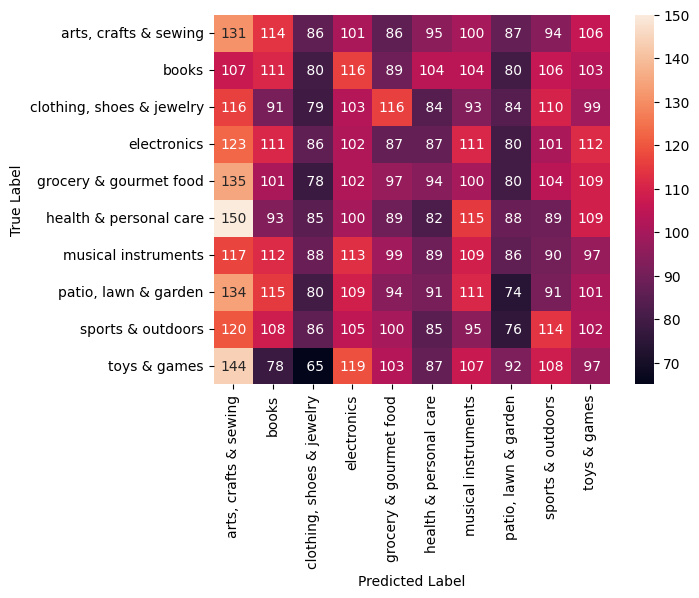

In [24]:
import seaborn as sns

# create a confusion matrix
y_test = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_test, predicted_labels)

# Convert to a pandas dataframe
confusion_df = pd.DataFrame(cm, index=class_names, columns=class_names)
confusion_df.index.name = 'True Label'
confusion_df.columns.name = 'Predicted Label'

sns.heatmap(confusion_df, annot=True, fmt='3g')

In [ ]:
 # Fit with data augmentation
# Note: if you run this AFTER calling
# the previous model.fit()
# it will CONTINUE training where it left off
batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
  width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
 
train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size
 
r = model.fit(train_generator, validation_data=(x_test, y_test),
              steps_per_epoch=steps_per_epoch, epochs=10)

Epoch 1/10
1562/1562 [==============================] - 69s 44ms/step - batch: 780.5000 - size: 31.9898 - loss: 0.5419 - acc: 0.8224 - val_loss: 0.5128 - val_acc: 0.8373
Epoch 2/10
1562/1562 [==============================] - 66s 42ms/step - batch: 780.5000 - size: 31.9898 - loss: 0.4446 - acc: 0.8508 - val_loss: 0.4659 - val_acc: 0.8462
Epoch 3/10
1562/1562 [==============================] - 66s 42ms/step - batch: 780.5000 - size: 31.9898 - loss: 0.4042 - acc: 0.8649 - val_loss: 0.4608 - val_acc: 0.8478
Epoch 4/10
1562/1562 [==============================] - 67s 43ms/step - batch: 780.5000 - size: 31.9898 - loss: 0.3862 - acc: 0.8707 - val_loss: 0.4454 - val_acc: 0.8531
Epoch 5/10
1562/1562 [==============================] - 67s 43ms/step - batch: 780.5000 - size: 31.9898 - loss: 0.3666 - acc: 0.8762 - val_loss: 0.4485 - val_acc: 0.8517
Epoch 6/10
1562/1562 [==============================] - 68s 43ms/step - batch: 780.5000 - size: 31.9898 - loss: 0.3483 - acc: 0.8815 - val_loss: 0.430